In [1]:
import correlation_steps as corrsteps
import correlation, h5py
import matplotlib.pyplot as plt
import numpy as np
import bead_util as bu

In [2]:
measurement_path = '/data/20170726/bead8_15um_QWP/steps/plates_and_flips/'
calibration_path = '/data/20170726/bead8_15um_QWP/steps/calibration_1positive/'

In [3]:
def getData(fname, calib=False):
    """ assumes fname ends with a '.h5' """
    #print 'getting data from ', fname
    fdrive = correlation.getFDrive(fname)  # Hz
    f = h5py.File(fname, 'r')
    dset = f['beads/data/pos_data']
    dat = np.transpose(dset)  # all this data is in volts
    dat = dat * 10./(2**15 - 1)
    x = dat[:, bu.xi]  # V
    Fs = dset.attrs['Fsamp']
    half_wavelength = int((Fs / fdrive) / 2.)  # bins
    x = x[:-half_wavelength]  # V
    gain, ACamp = correlation.getGainAndACamp(fname)  # unitless, V
    x_data = ((x - np.average(x)) / float(len(x))) / (gain * ACamp)  # unitless
    if calib:
        drive0 = dat[:, bu.drive]  # V
        drive = drive0 - np.average(drive0)
        drive_data = drive / np.std(drive)  # normalized, unitless drive
        return x_data, drive_data
    else:
        time = dset.attrs['Time']
        return x_data, time

def formData(mpath, cpath, change_c=0):
    index, c, drive_data = corrsteps.calibrate(cpath)
    if change_c != 0:c = change_c
    corr, t = ([] for i in range(2))
    for f in bu.time_ordered_file_list(mpath):
        #print f
        x_data, time = getData(f)
        corr.append(correlation.correlate(x_data, drive_data, index, c))
        t.append(time)
    return t, corr

In [ ]:
t, corr = formData(measurement_path, calibration_path)

In [10]:
e = correlation.charge_of_electron*correlation.num_electrons_in_sphere # Nm/V = C
d = 0.001 # m
V = 200*(7300.+13500.)/1000. # V
conversion = e*V/d # N/e

In [11]:
conversion

1389.18924976142

<IPython.core.display.Javascript object>


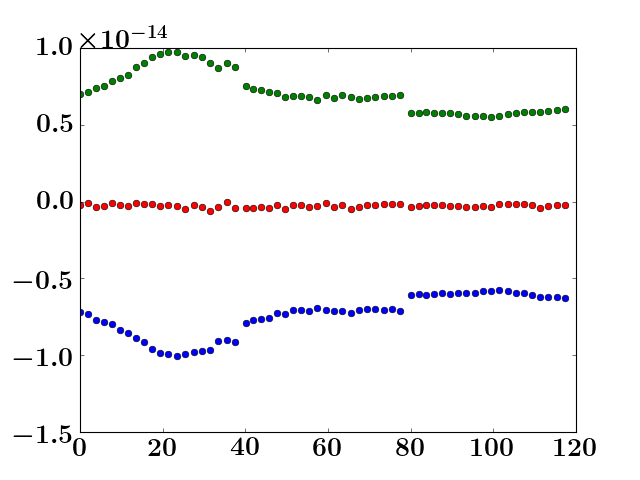

In [13]:
i = 0
if len(t[0::2]) != len(t[1::2]):
    i = 2
time_p = np.array(t[i::2])
time_n = np.array(t[1::2])
time = (time_p+time_n)/2.
time = time - time[0]
time = time/60.
corr_p = np.array(corr[i::2])*conversion
corr_n = np.array(corr[1::2])*conversion
corr_s = corr_p + corr_n

<IPython.core.display.Javascript object>


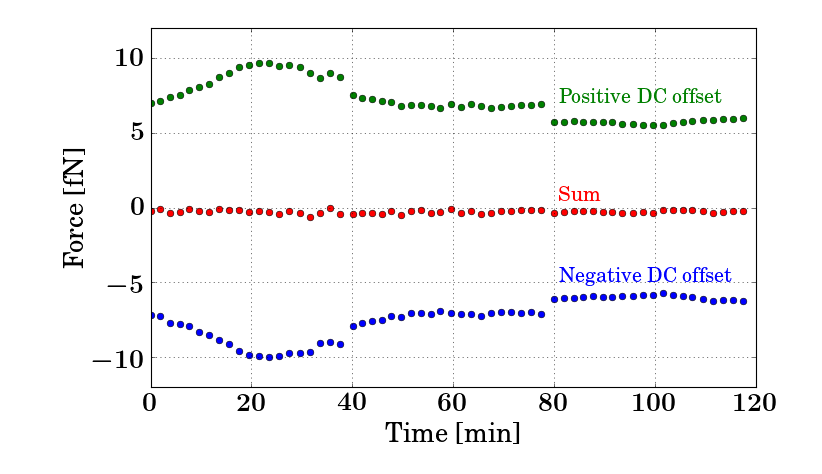

In [29]:
import matplotlib
%matplotlib notebook

plt.rc('text', usetex=True)
#plt.rc('font', family='serif')
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 24}
matplotlib.rc('font', **font)
matplotlib.rcParams['text.latex.preamble'] = [r'\boldmath']

plt.plot(time,1e15*corr_p,'bo', label='(+) DC')
plt.plot(time,1e15*corr_n,'go', label='(-) DC')
plt.plot(time,1e15*corr_s,'ro', label='sum')
plt.xlabel('Time [min]')
plt.ylabel('Force [fN]')
plt.ylim([-12,12])

#plt.text(2, 0.65e-16, r'$\cos(2 \pi t) \exp(-t)$', fontdict={'color':  'darkred', 'size': 16,})

#plt.legend(prop={'size': 22}, numpoints=1, loc=1)
plt.text(81,  7, r'Positive DC offset', fontdict={'color': 'green', 'size': 18})
plt.text(81,  0.5, r'Sum', fontdict={'color': 'red', 'size': 18})
plt.text(81, -5, r'Negative DC offset',                fontdict={'color': 'blue', 'size': 18})

# -DC, +DC, sum
plt.tight_layout()

plt.grid()
plt.show()

In [ ]:
plt.plot(time[::3],corr_p[::3],'o', label='(+) voltage')
plt.plot(time[::3],corr_n[::3],'o', label='(-) voltage')
plt.plot(time[::3],corr_s[::3],'o', label='sum')
plt.xlabel('time [s]')
plt.ylabel('correlation [e]')
plt.legend()
plt.show()

In [ ]:
# COMMENT THIS OUT IF THE SPHERE HASN'T FALLEN
# t, dc, corr = zip(*zip(t[:len(corr)/2], dc[:len(corr)/2], corr[:len(corr)/2]))

In [ ]:
dc_corr_list_pos = []
dc_corr_list_neg = [0]
i = 0
for i in range(len(corr)):
    if dc[i] < 0:
        dc_corr_list_pos[-1]+=corr[i]
        dc_corr_list_neg.append(corr[i])
    else:
        dc_corr_list_pos.append(corr[i])
        dc_corr_list_neg[-1]+=corr[i]
dc_corr_list_neg = dc_corr_list_neg[1:]
time_steps = t[::2]
time_steps = np.array(time_steps) - time_steps[0]

In [ ]:
from scipy.optimize import curve_fit
from scipy.stats import norm

def gaussian_distribution(x, A, u, sigma):
    return A * np.exp(-(x - u) ** 2 / (2 * sigma ** 2))

In [ ]:
%matplotlib notebook

# plot the figure
pn, binp, patchs = plt.hist(dc_corr_list_pos, bins=50, normed=True, alpha=0.6, color='b')
mup, stdp = norm.fit(dc_corr_list_pos)
nn, binn, patchs = plt.hist(dc_corr_list_neg, bins=50, normed=True, alpha=0.6, color='y')
mun, stdn = norm.fit(dc_corr_list_neg)

plt.xlabel('Correlation [e]')
plt.ylabel('Occurances of correlation value')

plt.title('Blue = Normal Pairing; Yellow = Next Pairing')

plt.show()

mp = float(max(pn))
mn = float(max(nn))

if mup > 0:
    lboundp = [0.1*mp, 0.1*mup, 0.1*stdp]
    uboundp = [1.2*mp, 1.2*mup, 1.2*stdp]
else:
    lboundp = [0.1*mp, 1.2*mup, 0.1*stdp]
    uboundp = [1.2*mp, 0.1*mup, 1.2*stdp]

if mun > 0:
    lboundn = [0.1*mn, 0.1*mun, 0.1*stdn]
    uboundn = [1.2*mn, 1.2*mun, 1.2*stdn]
else:
    lboundn = [0.1*mn, 1.2*mun, 0.1*stdn]
    uboundn = [1.2*mn, 0.1*mun, 1.2*stdn]

plt.figure()

x = sorted(list(set(np.concatenate((binp, binn)))))
p = norm.pdf(x, mup, stdp)
plt.plot(x, p, 'g', linewidth=2)
n = norm.pdf(x, mun, stdn)
plt.plot(x, n, 'r', linewidth=2)

xp = (binp[1:] + binp[:-1]) / 2.
xn = (binn[1:] + binn[:-1]) / 2.

poptp, pcovp = curve_fit(gaussian_distribution, xp, pn, bounds=(lboundp, uboundp))
perrp = np.sqrt(np.diag(pcovp))
fitted_data_p = gaussian_distribution(xp, *poptp)
plt.plot(xp, fitted_data_p, 'b')
plt.errorbar(xp, pn, yerr=np.sqrt(pn), fmt='bo')

poptn, pcovn = curve_fit(gaussian_distribution, xn, nn, bounds=(lboundn, uboundn))
perrn = np.sqrt(np.diag(pcovn))
fitted_data_n = gaussian_distribution(xn, *poptn)
plt.plot(xn, fitted_data_n, 'y')
plt.errorbar(xn, nn, yerr=np.sqrt(nn), fmt='yo')

plt.xlabel('Correlation [e]')
plt.ylabel('Occurances of correlation value')

plt.title('Blue/Green = First; Yellow/Red = Second')

plt.show()

In [ ]:
# print parameters
print 'fitting pos to gaussian gives:'
print '           mean = ', poptp[1], ' with error ', perrp[1]
print '    actual mean = ', mup
print ''
print '           standard deviation = ', poptp[2], ' with error ', perrp[2]
print '    actual standard deviation = ', stdp
print ''
print ''
print 'fitting neg to gaussian gives:'
print '           mean = ', poptn[1], ' with error ', perrn[1]
print '    actual mean = ', mun
print ''
print '           standard deviation = ', poptn[2], ' with error ', perrn[2]
print '    actual standard deviation = ', stdn